# 4. 인공 신경망

- 인공 신경망은 사람의 신경망을 모사하여 만든 예측 도구이다.
- 기본적으로 하나의 레이어에 다수의 노드를 가지고 있으며 여러 개의 레이어가 쌓인 신경망을 깊은 신경망이라고 한다.
- 이 때, 깊은 신경망을 이용하여 모델을 학습 시키는 방법을 딥러닝이라고 한다.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd/content/gdrive/My Drive/deeplearningbrov2/pytorch

/content/gdrive/My Drive/deeplearningbrov2/pytorch


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch import nn, optim # torch 내의 세부적인 기능을 불러온다. (신경망 기술, 손실함수, 최적화 방법 등)
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import torch.nn.functional as F # torch 내의 세부적인 기능을 불러온다. (신경망 기술 등)

## 4.1 데이터 불러오기

In [ ]:
import pandas as pd

df = pd.read_csv('./data/reg.csv', index_col=[0]) # 인덱스를 0번째 열로 설정함으로써 숫자 인덱스가 안 뜨게

In [ ]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,Price
0,0.034633,0.206919,0.137057,0.540526,0.193941,0.699239,0.630532,0.239410,0.027375,0.209857,0.347609,0.996394,0.102644,0.422222
1,0.028920,0.014315,0.276113,0.255945,0.618886,0.555407,0.782263,0.482977,0.103031,0.106690,0.520776,0.996650,0.187120,0.368889
2,0.020627,0.033230,0.281116,0.525591,0.165269,0.624102,0.586005,0.272713,0.036010,0.106986,0.595301,0.983284,0.084079,0.660000
3,0.022749,0.033801,0.125044,0.263253,0.251509,0.658532,0.432160,0.344932,0.150018,0.068317,0.651297,0.989989,0.015990,0.631111
4,0.022148,0.029374,0.121057,0.521126,0.399670,0.448086,0.520158,0.495342,0.104383,0.069360,0.560116,0.998723,0.092782,0.693333


## 4.2 데이터 변수와 타겟값 나누기

In [ ]:
# 데이터를 넘파이 배열로 만들기
X = df.drop('Price', axis=1).to_numpy() # 데이터프레임에서 타겟값(Price)을 제외하고 넘파이 배열로 만들기
Y = df['Price'].to_numpy().reshape((-1,1)) # 데이터프레임 형태의 타겟값을 넘파이 배열로 만들기

## 4.3 텐서 데이터와 배치 만들기

In [ ]:
# 데이터의 트레인 데이터 저장, 테스트 데이터 저장, 인덱싱, 데이터 길이를 반환하는 데이터셋 클래스를 오버라이딩하여서 데이터들을 텐서 데이터로 변환
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data) # 이미지 데이터를 FloatTensor로 변형
        self.y_data = torch.FloatTensor(y_data) # 라벨 데이터를 FloatTensor로 변형
        self.len = self.y_data.shape[0] # 데이터가 1차원 벡터일 때는  요소의 개수를, 데이터가 행렬일 때는 행 개수를 반환

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]  # 뽑아낼 데이터를 적어준다.

    def __len__(self):
        return self.len

In [ ]:
# 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.
# test size를 0.5로 설정한다.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

trainsets = TensorData(X_train, Y_train)
trainloader = DataLoader(trainsets, batch_size=32, shuffle=True)
# 데이터로더 함수: 데이터를 배치화하는 데에 중요한 옵션인 배치 사이즈, 셔플을 조정할 수 있음.

testsets = TensorData(X_test, Y_test)
testloader = DataLoader(testsets, batch_size=32, shuffle=False)

## 4.4 모델 구축

- Regressor 모델을 만들되 입력층(노드 13개), 2개의 은닉층(50, 30개), 출력층(1개)으로 구성한다.
- 데이터의 변수는 13개이므로 입력층의 노드는
13개가 되고 출력층은 집 값인 단일 값을 추출하는 것이므로 1개가 된다.
- 은닉층에 대해서는 실험을 하면서 튜닝할 수 있다.

In [ ]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(13, 50, bias=True) # 입력층(13) -> 은닉층1(50)으로 가는 연산
        self.fc2 = nn.Linear(50, 30, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.fc3 = nn.Linear(30, 1, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.dropout = nn.Dropout(0.2) # 드랍아웃 적용: 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 가린다.

    def forward(self, x): # 입력데이터 x를 매개변수로 받으며, 함수 안에서 모델 연산의 순서를 정의함.
        x = F.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 렐루를 적용한다.
        x = self.dropout(F.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, f1의 결과인 50개는 f를 거치며 30개가 되지만, 드랍아웃 덕분에 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        x = F.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 렐루를 적용한다. (가격 예측 문제이기 때문에 음의 값들은 말이 안된다. 그래서 렐루로 모두 0으로 만들어줌)

        return x

# 주의 사항
# 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제하고 계산하는 방식이기 때문에, 절대로 출력층에 사용해서는 안 된다.

## 4.5 모델, 손실함수, 최적화 방법 선언

In [ ]:
# 모델의 매개변수 출력
model = Regressor()
for name, param in model.named_parameters(): # .named_parameters()는 PyTorch 모델의 모든 매개변수를 이름과 함께 반환하는 메서드입니다.
    print(name, param.size())

fc1.weight torch.Size([50, 13])
fc1.bias torch.Size([50])
fc2.weight torch.Size([30, 50])
fc2.bias torch.Size([30])
fc3.weight torch.Size([1, 30])
fc3.bias torch.Size([1])


In [ ]:
model = Regressor()
criterion = nn.MSELoss() # 손실함수로 MSE를 채택

optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-7)
# weight_decay는 L2 정규화에서의 패널티 정도를 의미한다.
# L2 정규화는 손실함수를 갱신하는 과정이다.
# '가중치의 제곱합 * 람다'만큼의 패널티를 손실 함수에 추가하여 가중치를 갱신하는 방식.
# 이를 통해 특정 상황에 대해서 가중치가 너무 커져서 오버피팅이 발생하는 일을 방지한다.
# 참고로 1e-2 = 0.01

## 4.6 학습 진행
- 데이터를 배치로 나눔
- 배치끼리 셔플링
- 한 배치를 모델에 집어넣고, 예측값을 뽑아내어 정답과 비교하며 로스값을 구하고, 옵티마이저를 거침으로써 가중치 갱신
- 한 배치가 모델에 들어올 때마다 학습하는 반복문 한 가지
- 데이터의 배치를 다 썼을 때에 다시 전체 데이터를 채우고 위의 과정을 반복하는 반복문 한 가지
- 총 반복문 두 가지

In [ ]:
ep = 0
ls = 1 # 임의의 손실 임계값
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트
n = len(trainloader) # 배치의 개수

for epoch in range(200): # 200번 학습을 진행한다.

    running_loss = 0.0

    for data in trainloader: # '무작위로 섞인 32개 데이터가 있는 배치들'에서 배치가 하나씩 들어온다.

        inputs, values = data # data에는 X, Y가 들어있다.

        optimizer.zero_grad() # 옵티마이저는 이전 누적값을 반영한 채로 계산하기 때문에 새로운 계산을 할 때는 초기화가 필요하다

        outputs = model(inputs) # 모델에 입력값 대입 후 예측값 산출
        loss = criterion(outputs, values) # 예측값인 아웃풋과 정답인 벨류끼리 손실 함수 값 계산
        loss.backward() # 손실 함수 기준으로 역전파 계산하기로 선언하며 기울기를 계산한다.
        optimizer.step() # optimizer.step()은 위에서 계산된 기울기를 사용하여 가중치를 업데이트하는 메서드이다.

        running_loss += loss.item() # 평균 loss를 계산하기 위해 epoch 마다 배치 loss를 더한다.
        # n으로 나누는 계산을 위해서는 어차피 스칼라값만 필요하니까 .item()을 써서 텐서에서 스칼라값만 가져옴.

    l = running_loss/n
    loss_.append(l) # 손실 함수를 리스트에 축적


    # 유의미한 손실 함수 값이 나올 때마다 저장하기 위해서 조건문 설정
    if l < ls: # ls의 초기값은 1이다.
        ls = l # ㅣ값을 새로운 ls로 갱신하고,
        ep = epoch # 현재 에포크 수도 갱신하고,
        torch.save({'epoch': ep,
                    'loss': loss_,
                    'model': model.state_dict(), # 현재 모델의 파라미터(가중치와 편향)
                    'optimizer': optimizer.state_dict() #  옵티마이저의 상태(모멘텀 등)
                    }, './models/reg4-1.pt')
                    # 를 포함한 딕셔너리를 저장함.
        # 이프 조건문 을 만족할 때 모델의 상태를 저장.
        # 나중에 토치의 자체함수로 저장 이력을 불러올 수 있다.

print('Finished Training')

Finished Training


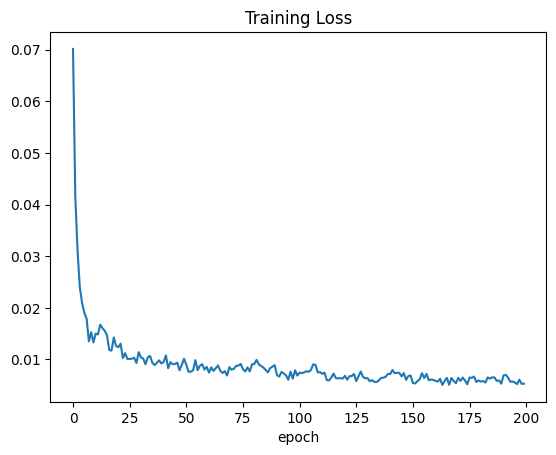

In [ ]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
checkpoint = torch.load ('./models/reg4-1.pt')
# 위에서 torch.save로 저장했던 이력을 torch.load함수로 가져옴.

model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
loss_ = checkpoint['loss']
ep = checkpoint['epoch']
ls = loss_[-1]
print(f"epoch={ep}, loss={ls}")

epoch=163, loss=0.005073651496786624


<ipython-input-24-c9415542d186>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load ('./models/reg4-1.pt')


## 4.7 모델 평가

In [ ]:
# MSE에 루트를 씌운 RMSE 계산.
# RMSE는 오차제곱에 다시 루트를 씌워주기 때문에 더 직관적이다.

def rmse(dataloader):

    with torch.no_grad(): # requires_grad: 비활성화. 파라미터의 기울기를 계산하지 않도록 하여 메모리 사용을 줄이고 계산 속도를 높임
        square_sum = 0 # 초기화
        num_instances = 0 # 초기화
        model.eval() # 평가를 할 때에는 드랍아웃을 비활성화하기 위해서 .eval()을 반드시 사용해야 한다.
        for data in dataloader:
            inputs, targets = data
            outputs = model(inputs)
            square_sum += torch.sum((outputs - targets)**2).item() # 텐서에서 어차피 스칼라값만 필요하니까 .item()로 스칼라값만 가져옴.
            num_instances += len(targets)

    model.train() # 위의 계산이 끝나면 model.eval()에서 model.train()으로 되돌려주기 위해서
    return np.sqrt(square_sum/num_instances)

# 평가 시 .eval()을 사용해야 하는 이유
# 평가 시에는 정규화 기술을 배제하여 온전한 모델로 평가를 해야한다. 따라서 .eval()을 사용한다.
# 즉, 드랍아웃이나 배치 정규화 등과 같이 학습 시에만 사용하는 기술들이 적용 된 모델은 평가 시에는 비활성화 해야하며 학습 시 .train()을 사용한다.

In [ ]:
train_rmse = rmse(trainloader) # 학습 데이터의 RMSE
test_rmse = rmse(testloader) # 시험 데이터의 RMSE

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

# 예시를 위한 단순 비교입니다. 실제 연구에서는 디테일한 비교가 필요합니다.
# 예를 들어 20번의 평가 결과의 평균과 표준편차로 우위 비교를 하거나 신뢰구간을 이용합니다.
# 데이터를 무작위로 나누고 모델의 초기값도 random initial parameter를 사용했기 때문에 학습을 할 때 마다 결과가 다르게 나올 수 있습니다.
# 이 강의에서는 학습의 흐름(for문)과 모델(Regressor) 부분을 주의 깊게 보시면 됩니다.

Train RMSE: 0.06976567336089397
Test RMSE: 0.12065991742664979
